In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
from scipy.stats import percentileofscore
from scipy.interpolate import UnivariateSpline

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
########################################
### Functions for path interpolation ###
########################################

def getPathLength(x, y):
    dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
    return np.sum(dr)
    
def splinePath(x, y, N, z=None):
    """Takes a set of (x,y) coordinates, spline along z if provided,
    otherwise along its path. Finally, interpolate at N equal
    distance points.  Return 2 or 3 size N numpy arrays representing
    interpolated N (x,y) or (x,y,z) coordinates.
    """
    if z is None:
        dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
        r = np.zeros_like(x)
        r[1:] = np.cumsum(dr) # integrate path
        r_int = np.linspace(0, r.max(), N) # regular spaced path
        z, z_int = r, r_int
        splx = UnivariateSpline(z, x, s=0, ext='const') # interpolate
        # splx.set_smoothing_factor(0.5)
        x_int = splx(z_int)
        sply = UnivariateSpline(z, y, s=0, ext='const')
        # sply.set_smoothing_factor(0.5)
        y_int = sply(z_int)
        return x_int, y_int
    if z is not None:
        # check whether z is increasing -- requied for spline interpolate
        dz = np.diff(z)
        if not np.all(dz >= 0):
            exit('z for splinePath is not increasing!')
        z_int = np.linspace(z.min(), z.max(), N)
        splx = UnivariateSpline(z, x, s=0, ext='const') # interpolate
        # splx.set_smoothing_factor(0.5)
        x_int = splx(z_int)
        sply = UnivariateSpline(z, y, s=0, ext='const')
        # sply.set_smoothing_factor(0.5)
        y_int = sply(z_int)
        return x_int, y_int, z_int

def discretizePath(x, y, N, z=None):
    """Similar to splinePath, but do linear interpolation instead of spline.
    Takes a set of (x,y) coordinates, interpolate N points along z if provided,
    otherwise along its path. Return 2 or 3 size N numpy arrays representing
    interpolated N (x,y) or (x,y,z) coordinates.
    """
    if z is None:
        dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
        r = np.zeros_like(x)
        r[1:] = np.cumsum(dr) # integrate path
        r_int = np.linspace(0, r.max(), N) # regular spaced path
        x_int = np.interp(r_int, r, x) # interpolate
        y_int = np.interp(r_int, r, y)
        return x_int, y_int
    if z is not None:
        z_int = np.linspace(z.min(), z.max(), N)
        x_int = np.interp(z_int, z, x) # interpolate
        y_int = np.interp(z_int, z, y)
        return x_int, y_int, z_int

def get_polyline_df(inputFolder, N=100, z_interp_spacing=1, VOXEL_DEPTH=2.0):
    """Takes a list of .txt files storing ordered coordinates of polylines
    at relatively sparse z slices at a single time point, interpolate to
    generate a set of smoothened polylines.
    
    Input Parameters
    ----------------
    inputFolder:
            The folder containing a series of txt files that each has a list
        of ordered x,y coordinates. The file name of each txt file indicates
        the z slice and time frame.
    
    N:
        The number of points to interpolate along path.
    
    z_interp_spacing:
        In microns, used to compute number of z planes to interpolate along z.
        
    VOXEL_DEPTH:
        The z interval of the image stack used to convert slice number to microns.
    
    Returns
    -------
    polyline_df:
        A pandas data frame containing organized 3D coordinates with
    6 columns: x, y, z, t, pathPos, zPos.
    First, it reads in the series of x,y coordinates, interpolate equal
    distance points along the spline fitted line for plotting on the
    corresponding z plane and time point.

    Second, it takes the ordered set of x,y,z points along the polyline path,
    spline and interpolate again to get a dense enough mesh grid points
    at each time point.

    Third, it interpolate along the time line to make sure every time point
    has a mesh grid representing the bud surface.

    Finally, all data will be saved into a pandas DataFrame, which is returned.
    """
    fileList = glob.glob(inputFolder+'*.txt')
    fileList.sort()

    xyData, tzData = [], []
    for f in fileList:
        xyData.append(pd.read_csv(f, sep='\t', header=None))
        f = f.split('/')[-1]
        f = f.split('.')[0]
        tzData.append([int(s) for s in f.split('-') if s.isdigit()])
    tzData = np.array(tzData)
    # print(xyData)
    # print(tzData)

    # interpolate along each path to position crosslines
    pathData = []
    for i in range(len(xyData)):
        temp = xyData[i].values
        x, y = temp[:,0], temp[:,1]
        try:
            x_int, y_int = splinePath(x, y, N)
        except: # exception will rise when there are only 2 or 3 points
            x_int, y_int = discretizePath(x, y, N)
        # The following is time series in frame number
        tempT = np.ones_like(x_int) * tzData[i,0]
        # The following is z slice in microns
        tempZ = np.ones_like(x_int) * tzData[i,1] * VOXEL_DEPTH
        # Record the point position along path
        pathPos = np.arange(N)
        tempDF = pd.DataFrame([x_int, y_int, tempZ, tempT, pathPos])
        tempDF = tempDF.transpose()
        pathData.append(tempDF)
    # concat all data into one big pandas data frame
    pathDF = pd.concat(pathData, ignore_index=True)
    pathDF.columns = ['x', 'y', 'z', 't', 'pathPos']

    # # select a subset of the data
    # pathDF = pathDF.loc[pathDF.z >= 9*VOXEL_DEPTH]
    # pathDF = pathDF.loc[pathDF.z <= 38*VOXEL_DEPTH]
    # pathDF = pathDF.loc[pathDF.t >= 131]

    # interpolate along crosslines to get meshes for existing time points
    meshData = []
    for t in pathDF.t.unique():
        pathDF_t = pathDF.loc[pathDF.t == t]
        for i in pathDF_t.pathPos.unique():
            pathDF_ti = pathDF_t.loc[pathDF_t.pathPos == i]
            temp = pathDF_ti.sort_values('z', ascending=True)
            x, y, z = temp.x, temp.y, temp.z
            # Specify the number of interpolated z planes
            N_CROSS = int(( np.max(z) - np.min(z) + 1 ) / z_interp_spacing)
            # no exception handling since z length should always be more than 3
            x_int, y_int, z_int = splinePath(x, y, N_CROSS, z)
            # x_int, y_int, z_int = discretizePath(x, y, N_CROSS, z) # linear
            tempT = np.ones_like(x_int) * t
            tempPos = np.ones_like(x_int) * i
            tempPosZ = np.arange(len(z_int))
            tempDF = pd.DataFrame([x_int, y_int, z_int, tempT, tempPos, tempPosZ])
            tempDF = tempDF.transpose()
            meshData.append(tempDF)
    meshDF = pd.concat(meshData, ignore_index=True)
    meshDF.columns = ['x', 'y', 'z', 't', 'pathPos', 'zPos']
    
    return meshDF


In [3]:
# Note: some glitch in imagej macro made the x coordinates in pixel units, so x is scaled
# here with the pixel size to transform into microns for both data sets

inputFolder = '../data/3D-polylines-for-mesh/xy-view/'
polyline_df_xy = get_polyline_df(inputFolder, N=200, z_interp_spacing=0.62, VOXEL_DEPTH=2.0)
polyline_df_xy.loc[:,'x'] = polyline_df_xy.x * .62
polyline_df_xy.to_csv('../data/3D-polylines-for-mesh/polyline_df_xy.csv')

inputFolder = '../data/3D-polylines-for-mesh/yz-view/'
polyline_df_yz = get_polyline_df(inputFolder, N=200, z_interp_spacing=0.62, VOXEL_DEPTH=0.62)
# This x in the z sliced view of the stack was flipped, so use 151*.62=93.62 um to convert
# it to match the original z coordinate
polyline_df_yz.loc[:,'x'] = 93.62 - polyline_df_yz.x * .62
polyline_df_yz.to_csv('../data/3D-polylines-for-mesh/polyline_df_yz.csv')


2020-05-06 21:13:03,785 - INFO - NumExpr defaulting to 8 threads.


In [4]:
tMin, tMax = polyline_df_xy.t.min(), polyline_df_xy.t.max()
xMin, xMax = polyline_df_xy.x.min(), polyline_df_xy.x.max()
yMin, yMax = polyline_df_xy.y.min(), polyline_df_xy.y.max()
zMin, zMax = polyline_df_xy.z.min(), polyline_df_xy.z.max()
print(xMax - xMin, yMax - yMin, zMax - zMin)

218.38474532448564 171.0546109887161 72.0


In [5]:
tMin, tMax = polyline_df_yz.t.min(), polyline_df_yz.t.max()
xMin, xMax = polyline_df_yz.x.min(), polyline_df_yz.x.max()
yMin, yMax = polyline_df_yz.y.min(), polyline_df_yz.y.max()
zMin, zMax = polyline_df_yz.z.min(), polyline_df_yz.z.max()
print(xMax - xMin, yMax - yMin, zMax - zMin)

93.27023121780464 163.36835518028798 179.8


In [6]:
def plot_3D_polylines_xy(polyline_df_xy, t, ax, line_color, line_alpha):
    tMin, tMax = polyline_df_xy.t.min(), polyline_df_xy.t.max()
    xMin, xMax = polyline_df_xy.x.min(), polyline_df_xy.x.max()
    yMin, yMax = polyline_df_xy.y.min(), polyline_df_xy.y.max()
    zMin, zMax = polyline_df_xy.z.min(), polyline_df_xy.z.max()
    shift_x, shift_y, shift_z = np.mean([xMax, xMin]), np.mean([yMax, yMin]), np.mean([zMax, zMin])
    
    polyline_df_xy_t = polyline_df_xy.loc[polyline_df_xy.t == t]
    # plot the horizontal lines pf mesh
    for i in polyline_df_xy_t.z.unique():
        temp = polyline_df_xy_t.loc[polyline_df_xy_t.z == i]
        x, y, z = temp.x.values, temp.y.values, temp.z.values
        ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color=line_color, alpha=line_alpha, lw=0.2)

def plot_3D_polylines_yz(polyline_df_yz, t, ax, line_color, line_alpha):
    tMin, tMax = polyline_df_yz.t.min(), polyline_df_yz.t.max()
    xMin, xMax = polyline_df_yz.x.min(), polyline_df_yz.x.max()
    yMin, yMax = polyline_df_yz.y.min(), polyline_df_yz.y.max()
    zMin, zMax = polyline_df_yz.z.min(), polyline_df_yz.z.max()
    shift_x, shift_y, shift_z = np.mean([xMax, xMin]), np.mean([yMax, yMin]), np.mean([zMax, zMin])
    
    polyline_df_yz_t = polyline_df_yz.loc[polyline_df_yz.t == t]
    # plot the horizontal lines pf mesh
    for i in polyline_df_yz_t.z.unique():
        temp = polyline_df_yz_t.loc[polyline_df_yz_t.z == i]
        x, y, z = temp.x.values, temp.y.values, temp.z.values
        ax.plot(z-shift_z, y-shift_y, x-shift_x, '-', color=line_color, alpha=line_alpha, lw=0.2)


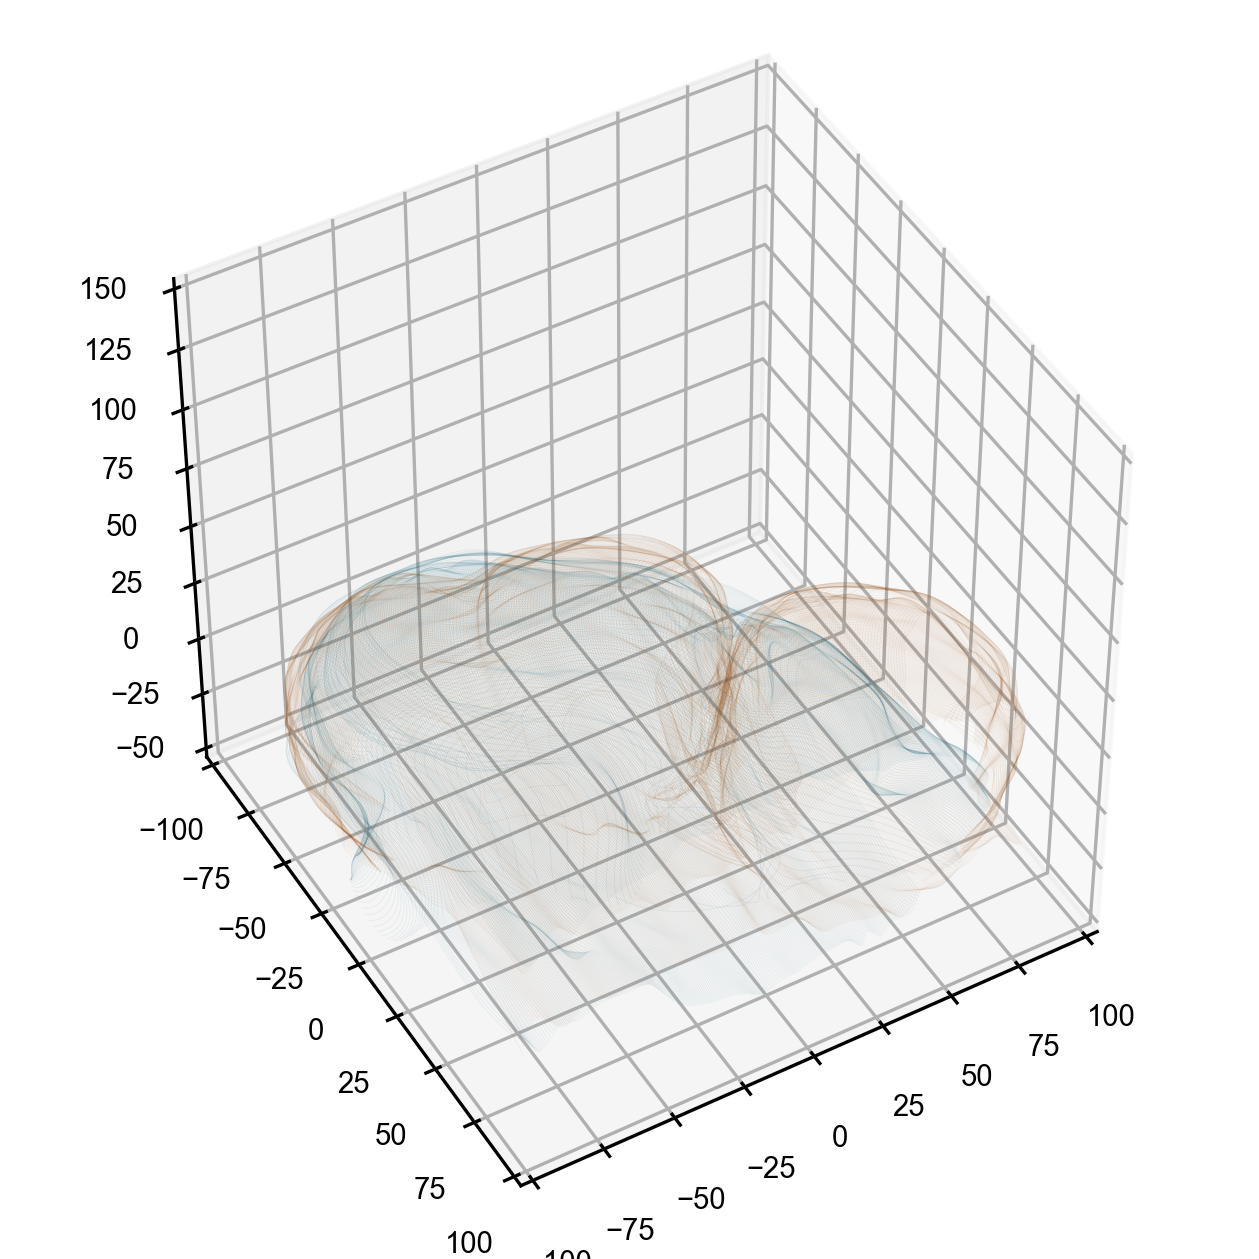

In [7]:
fig = plt.figure(figsize=(4, 4), dpi=300)
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ax = fig.add_axes([0, 0, 1.0, 1.0], projection='3d')

plot_3D_polylines_xy(polyline_df_xy, 1, ax, line_color='#1A6A82', line_alpha=0.08)
plot_3D_polylines_xy(polyline_df_xy, 192, ax, line_color='#A05B22', line_alpha=0.08)

plot_3D_polylines_yz(polyline_df_yz, 1, ax, line_color='#1A6A82', line_alpha=0.08)
plot_3D_polylines_yz(polyline_df_yz, 192, ax, line_color='#A05B22', line_alpha=0.08)

# *** adjust axis limits and turn on/off grids -- has to be after plotting ***
ax.set_xlim( -100, 100 )
ax.set_ylim( -100, 100 )
ax.set_zlim( -50, 150 )

# Set elevation and azimuth angles for viewpoint settting
# ax.view_init(90, 90)
ax.view_init(45, 60)

# Flip the y-axis to match the image coordinates
plt.gca().invert_yaxis()

# plt.axis('off')